# Introduction to Bayesian inference

Modern Bayesian models are in the class of computationally intensive models. Bayesian models are a rich class of models, which can provide attractive alternatives to frequentist models. Bayesian methods don't necessarily refer to a particular set of algorithms, but rather to a different approach to estimation. For example, we talk about regression and Bayesian regression, deep learning and Bayesian deep learning. In the context of hypothesis testing, we can also talk about Bayesian hypothesis testing. For this reason, **statistical inference** is divided between these two schools of thought: Frequentist and Bayesian paradigms. When the word **Bayesian** is not explicitly mentioned, we are relying on the frequentist paradigm, although the word frequentist is rarely mentioned.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import itertools

### The hair eye color problem

Let's begin with an example of Bayes' rule applied to a problem. A sample population has the following probabilities of eye and hair color combinations.

In [4]:
prob_E_and_H = np.array([
    [0.11, 0.2 , 0.04, 0.01],
    [0.03, 0.14, 0.03, 0.16],
    [0.03, 0.09, 0.03, 0.02],
    [0.01, 0.05, 0.02, 0.03]])

hair_colors = ['black', 'brunette', 'red', 'blond']
eye_colors = ['brown', 'blue', 'hazel', 'green']

prob_E_and_H = pd.DataFrame(prob_E_and_H, columns = hair_colors, index = eye_colors)
prob_E_and_H

,black,brunette,red,blond
brown,0.11,0.20,0.04,0.01
blue,0.03,0.14,0.03,0.16
hazel,0.03,0.09,0.03,0.02
green,0.01,0.05,0.02,0.03


In [5]:
prob_E_and_H.sum().sum()

1.0

Note that we're using a string index for eye color rather than a numeric zero-based index. So here's the easiest way to access a given (eye, hair) color value.

In [7]:
prob_E_and_H.loc['hazel', 'red']

0.03

The probabilities in the table above are **joint probabilities**, i.e. $P(E \cap H)$ if $E$ is eye color and $H$ is hair color. Given the joint probabilities, it is easy to compute the **marginal probabilities** $P(E)$ and $P(H)$ by summing the probabilities across rows and columns. Add a row and column to the data, containing the marginal probabilites of eye color and hair color.

In [9]:
prob_E_and_H_mar = prob_E_and_H.copy()
prob_E = prob_E_and_H.sum(axis = 1)
prob_H = prob_E_and_H.sum(axis = 0)

prob_E_and_H_mar.loc[:, 'prob_E'] = prob_E
prob_E_and_H_mar.loc['prob_H', :] = prob_H
prob_E_and_H_mar.loc['prob_H', 'prob_E'] = prob_E_and_H.values.sum()
prob_E_and_H_mar

,black,brunette,red,blond,prob_E
brown,0.11,0.20,0.04,0.01,0.36
blue,0.03,0.14,0.03,0.16,0.36
hazel,0.03,0.09,0.03,0.02,0.17
green,0.01,0.05,0.02,0.03,0.11
prob_H,0.18,0.48,0.12,0.22,1.00


Let's now compute $P(H|E = \text{blue})$. In other words, what is the distribution of hair color for people with blue eyes. You do not need to use Bayes' theorem here, just the conditioning rule:

$$P(H|E) = \frac{P(H \cap E)}{P(E)}$$

In [11]:
prob_H_given_E = prob_E_and_H.copy()

for hair in hair_colors:
    for eye in eye_colors:
        prob_H_given_E.loc[eye, hair] = prob_E_and_H.loc[eye, hair] / prob_E[eye]

prob_H_given_E

,black,brunette,red,blond
brown,0.305556,0.555556,0.111111,0.027778
blue,0.083333,0.388889,0.083333,0.444444
hazel,0.176471,0.529412,0.176471,0.117647
green,0.090909,0.454545,0.181818,0.272727


And let's also compute $P(E|H)$. In other words, what is the distribution of eye color given hair color.

In [13]:
prob_E_given_H = prob_E_and_H.copy()

for hair in hair_colors:
    for eye in eye_colors:
        prob_E_given_H.loc[eye, hair] = prob_E_and_H.loc[eye, hair] / prob_H[hair]

prob_E_given_H

,black,brunette,red,blond
brown,0.611111,0.416667,0.333333,0.045455
blue,0.166667,0.291667,0.250000,0.727273
hazel,0.166667,0.187500,0.250000,0.090909
green,0.055556,0.104167,0.166667,0.136364


As you can see, we were able to compute $P(E|H)$ and $P(H|E)$, and we didn't need Bayes' theorem to do it. Bayes' theorem is useful if one of these probabilities is easy to find, but the other one not. But just for the sake of it, let's use Bayes' rule anyway to compute $P(E|H)$. If all works well, we should get the same result as above. Here's the theorem:

$$P(E|H) = \frac{P(H|E)P(E)}{P(H)}$$

In [15]:
prob_E_given_H = prob_E_and_H.copy()

for hair in hair_colors:
    for eye in eye_colors:
        prob_E_given_H.loc[eye, hair] = prob_H_given_E.loc[eye, hair] * prob_E[eye] / prob_H[hair]

prob_E_given_H

,black,brunette,red,blond
brown,0.611111,0.416667,0.333333,0.045455
blue,0.166667,0.291667,0.250000,0.727273
hazel,0.166667,0.187500,0.250000,0.090909
green,0.055556,0.104167,0.166667,0.136364


And we can see that either way we get the same thing. So this should give you faith in how Bayes' rule works, almost magically.

Assume now that we don't want to rely on $P(E)$ and $P(H)$ as calculated in the data (sample). Instead, let's say we have country-wide statistics about eye color in the population, as shown here:

In [17]:
prob_E_pop = prob_E.copy()
prob_E_pop[:] = [0.35, 0.25, 0.25, 0.15]
prob_E_pop

brown    0.35
blue     0.25
hazel    0.25
green    0.15
dtype: float64

We can calculate $P(H)$ based on the above values for $P(E)$ and using the formula

$$P(H) = \sum_E P(H,E) = \sum_E P(H|E)P(E)$$

where the first summation is how we marginalize $E$ and the second summation is derived by writing the joint probability as a conditional probability.

In [19]:
prob_H_new = prob_H.copy()
prob_H_new[:] = 0

for eye in eye_colors:
    prob_H_new += prob_H_given_E.loc[eye, :] * prob_E_pop[eye]

prob_H_new
#P(H = black) = SUM_eyes( P(H = black| E = brown)*P(E = brown) ... )
#P(H = black) = SUM_eyes( 0.305 * 0.36 + 0.083*0.36 + 0.176*0.17 + 0.091*0.11 )
#P(H = black) = SUM_eyes( 0.11 + 0.03 + 0.03 + 0.01 )
#P(H = black) = 0.18

black       0.185532
brunette    0.492201
red         0.131113
blond       0.191154
dtype: float64

Finally, we can recalculate $P(E|H)$ with Bayes' theorem, but using the new values for $P(E)$ and the updated values for $P(H)$.

In [21]:
prob_E_given_H_new = prob_E_and_H.copy()

for hair in hair_colors:
    for eye in eye_colors:
        prob_E_given_H_new.loc[eye, hair] = prob_H_given_E.loc[eye, hair] * prob_E_pop[eye] / prob_H_new[hair]

prob_E_given_H_new

,black,brunette,red,blond
brown,0.576421,0.395051,0.296607,0.050861
blue,0.112290,0.197525,0.158897,0.581264
hazel,0.237790,0.268900,0.336487,0.153864
green,0.073499,0.138524,0.208010,0.214011


So by changing our prior, we can see thet we get a new posterior distribution $P(E|H)$. Notice for example that the probability of being blond given that you have blue eyes has dropped in the new calculation. This is because we assume we have overall fewer blue-eyed people in the population than what was suggested by the data.

### The billiards game

Let's now return to the billiards game we learned in class. Review the slides if you need to: We saw how the **Bayesian** approach to solving this probelm works. Here we just share the analytical solution:

$$P(B|D) = \frac{\int_0^1p^3(1-p)^5p^3dp}{\int_0^1(1-p)^5p^3dp} = \frac{\int_0^1(1-p)^5p^6dp}{\int_0^1(1-p)^5p^3dp} \approx 0.09$$

Now let's see how we could solve this if we didn't know the analytical solution. Notice that since the above integration only involved polynomial terms, we can solve it analytically without difficulty, but what if the integration is hard? We are going to show you three ways:

(1) The first way consists of just numerically approximating the above solution. It doesn't involve any statistics, just calculus and more specifically a Riemann approximation:

$$P(B|D) \approx \frac{\sum_{i = 1}^{n} p^3(1-p)^5p^3\Delta p}{\sum_{i = 1}^{n} (1-p)^5p^3\Delta p}$$

which is implemented here:

In [24]:
delta_p = 0.00001
n = int(1/delta_p)
p_range = np.linspace(0, 1, num = n)

numerator = np.sum([p**3 * (1-p)**5 * p**3 * delta_p for p in p_range])
denominator = np.sum([(1-p)**5 * p**3 * delta_p for p in p_range])
numerator / denominator

0.0909090909090909

Let's now look at another way to solve it: Arguably it's an even easier way because we are just drawing random numbers $p$ from the uniform distribution, then feeding the results to the equation:

In [26]:
p = np.random.uniform(size = n)
prob_p = np.ones(n) / n
prob_D_given_p = p**3 * (1-p)**5
prob_B_given_Dp = p**3
numerator = np.sum(prob_B_given_Dp * prob_D_given_p * prob_p)
denominator = np.sum(prob_D_given_p * prob_p)
numerator / denominator

0.09112322307135555

Either way we can see that the results are close, however the second method is more powerful because it makes fewer assumption about the function. In practice, Bayesian inference relies heavily on numerical methods like the above, albeit more sophisticated ones involving multiple variables and dependencies between them.

Finally, here's a third approach that is the more "data-sciency" of the three. Recall that the frequentist approach gave Bob a probability of 5% to win and the Bayesian approach gave him a probability of 9%. So who's right? We can use Monte Carlo simulations to create such a scenario and let it play out over and over again.

In [28]:
wins_B_ratio = []
hard_wins, wins_B = 0, 0 #set win counts as initially 0
n_iters = 10

for ii in range(1000): #number of games/simulations
    for _ in range(n_iters): # number of rounds in one game
        p = np.random.uniform(size = 1) #choose a random number between 0 and 1 with a length of 1
        points_A, points_B = 0, 0 #initially set the points as 0
        is_hard_win = False #set anybody's winning flag as "False"
        while points_A < 6 and points_B < 6: #loop while both points are less than 6 (winning score), i.e. playing the game
            if points_A == 5 and points_B == 3:
                is_hard_win = True
                hard_wins += 1 #count this exact scenario (of current score)
            r = np.random.uniform(size = 1)  #randomly choose a number between 0 and 1 with a length of 1
            if r < p:
                points_B += 1 #attribute this as B wins a point
            else:
                points_A += 1 #attribute this as A wins a point
        if is_hard_win and points_B == 6:
            wins_B += 1 #increase B's win count

    #print(wins_B / hard_wins)
    wins_B_ratio += [wins_B / (hard_wins + 1)] # we add 1 to avoid division by 0
    

Notice how the above method involves little knowledge of math, but to compensate for it we need to think out the simulation. Also

C:\Users\Alissa\AppData\Local\Temp\ipykernel_21004\3489976161.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wins_B_ratio);


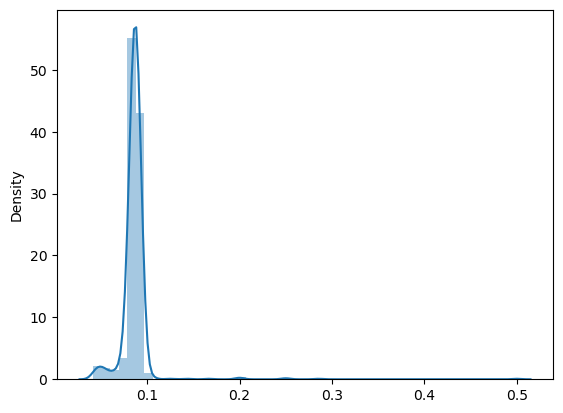

In [30]:
sns.distplot(wins_B_ratio);

In [31]:
np.mean(wins_B_ratio)

0.08646932410175862

It looks like at least in this case the Bayesians win!

## Bayesian inference in practice

In practice, the posterior distribution is estimated using computational methods as implemented in packages like `pymc` or `pystan`, with us only having to specify priors and provide the data. Here's a summary of a typical workflow:

1. Identify data relevant to the research question.
1. Define a descriptive model for the data. For example, pick a linear model formula.
1. Specify a prior distribution of the parameters.
1. Let the package run through the computation to estimate the posterior distribution.
1. Update the posterior distribution if more data is observed. This is key! The posterior of a Bayesian model naturally updates as more data is added, a form of **online learning**. With frequentist methods, as new data comes in we often have to **retrain** the model (but not always).
1. If needed, we can than simulate data values from realizations of the posterior distribution of the parameters.

Of the steps outlined above, choosing a prior distribution is the only steps that is somewhat left to chance. In general, a prior must be convincing to a skeptical audience, and if needed we can perform the analysis using different priors in order to see how sensitive the analysis is to the choice of the prior distribution. When trying to make an educated guess about priors, we can follow some approaches, such as

- letting past observations determine the prior
- using domain knowledge or theory
- use a **non-informative prior** such as the uniform distribution (but we still need to specify the range)
 
One analytically and computationally simple choice is a **conjugate prior**: When a likelihood is multiplied by a conjugate prior the distribution of the posterior is the same as the prior. Most named distributions have conjugates. A few commonly used examples are shown in the table below:

Likelihood | Conjugate
---|---
Binomial|Beta
Bernoulli|Beta
Poisson|Gamma
Categorical|Dirichlet
Normal| Normal, Inverse Gamma

However, there are many practical cases where a conjugate prior is not used.

## A simple example

With a bit of theory in mind, let's pull things together with an example. Let's say we are interested in analyzing distracted drivers. We sample the behavior of 10 drivers at an intersection and determine if they exhibit signs of distracted driving or not. The data is binomially distributed: a driver is distracted or not. Here's what we cover in this example:

- How to select a prior for the parameter $p$, the probability of distracted driving.
- How to compute the likelihood from the data.
- How to estimate the posterior distributions.
- Try another prior distribution to compare results.
- Add more data to our data set to update the posterior distribution.

The likelihood of the data and the posterior distribution are binomially distributed. The binomial distribution has one parameter we need to estimate, $p$, the probability of success (if you can call distracted driving a success!). We can write this formally for $k$ successes in $n$ trials:

$$ P(K = k) = \binom{n}{k} \cdot p^k(1-p)^{n-k}$$

The code in the cell below creates a simple data set of distracted drivers and computes some simple summary statistics.

In [35]:
drivers = ['yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes']
distracted = [1 if x is 'yes' else 0 for x in drivers]
distracted

<>:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\Alissa\AppData\Local\Temp\ipykernel_21004\1626429309.py:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  distracted = [1 if x is 'yes' else 0 for x in drivers]


[1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

In [36]:
n = len(distracted)  # sample size
n_distracted = sum(distracted)  # number of distracted drivers
n_not = n - n_distracted # number not distracted
print('Distracted drivers = %d Attentive drivers = %d \nProbability of distracted driving = %.1f' \
      % (n_distracted, n_not, n_distracted / (n_distracted + n_not)))

Distracted drivers = 4 Attentive drivers = 6 
Probability of distracted driving = 0.4


The following helper function will later help us visualize the results.

In [38]:
def plot_pp(x, p, l, pp):
    sns.lineplot(x=x, y=l, color = 'lightgrey', linewidth = 10,label='likelihood')
    sns.lineplot(x=x, y=p, color = 'blue', linewidth = 2,label='prior')
    sns.lineplot(x=x, y=pp, color = 'red', linewidth = 2,label='posterior')
    plt.xlabel('p')
    plt.ylabel('PDF of p')
    plt.title('Prior, likelihood and posterior distributions')
    #plt.legend(labels = ['likelihood', 'prior', 'posterior'])
    return None

Let's select a prior distribution $P(p)$ for our one model parameter $p$. We don't know a lot about drivers at this point, so we choose a uniform distribution ranging from 0 to 1.

In [40]:
n = 100
# prior = np.random.uniform(size = n)
x = np.linspace(0, 1, num = n)
prior = np.ones(n) * 1/n

print(x)
print(prior)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

Next, we need to compute the likelihood. We can view the observation of each driver as distracted or not as a Bernoulli trial, so the number of distracted drivers follows a binomial distribution with $n$ trials and a probability $p$ of a driver being distracted. The likelihood is the probability of the data given the parameter $p$.

In [42]:
def likelihood(p, data):
    k = int(sum(data))
    N = len(data)
    # l = scipy.special.comb(N, k) * p**k * (1-p)**(N-k) # compute Binomial likelihood
    l = scipy.stats.binom.pmf(k, N, p)
    return l / l.sum() # normalize the likelihood to sum to unity

like = likelihood(x, distracted)

Now that we have a prior and a likelihood we are in a position to compute the posterior distribution $P(p|X)$ of the parameter $p$. The code in the cell below computes and plots the posterior, given the prior and likelihood.

***
<span style="color: magenta;">**Warning!**</span>  The computational methods used in this notebook are simplified for the purpose of illustration. For real-world problems, computationally efficient code must be used!
***

In [44]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

post = posterior(prior, like)

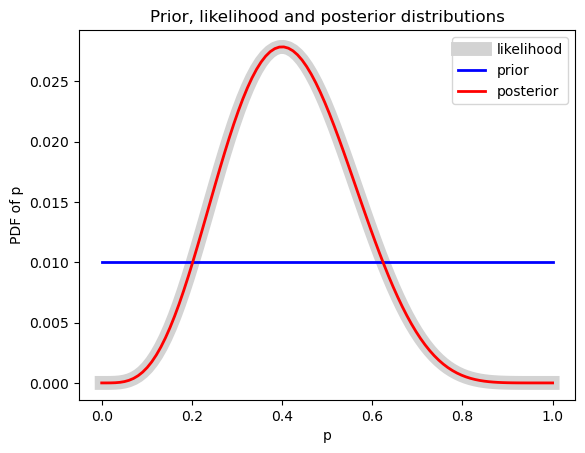

In [45]:
plot_pp(x, prior, like, post)

In [46]:
print('Maximum likelihood = %.3f' % x[np.argmax(like)])
print('MAP = %.3f' % x[np.argmax(post)])

Maximum likelihood = 0.404
MAP = 0.404


Notice that with uniform prior distribution, the posterior is just the likelihood. This is an important observation. The key point is that the frequentist probabilities are identical to the Bayesian posterior distribution given a uniform prior.  

### Another Prior

Let's try another prior distribution. We will chose the **conjugate prior** of the Binomial distribution which is the beta distribution. Formally, we can write the beta distribution:

$$\text{Beta}(p | a, b) = \kappa x^{a-1}(1 - x)^{b-1}$$

where $\kappa$ is a normalization constant.

The beta distribution is defined on the interval $0 \le \text{Beta}(p | a,b) \le 1$. The beta distribution has two parameters, $a$ and $b$, which determine the shape. To get a feel for the beta distribution, execute the code in the cell below which computes 100 examples on a 10x10 grid.

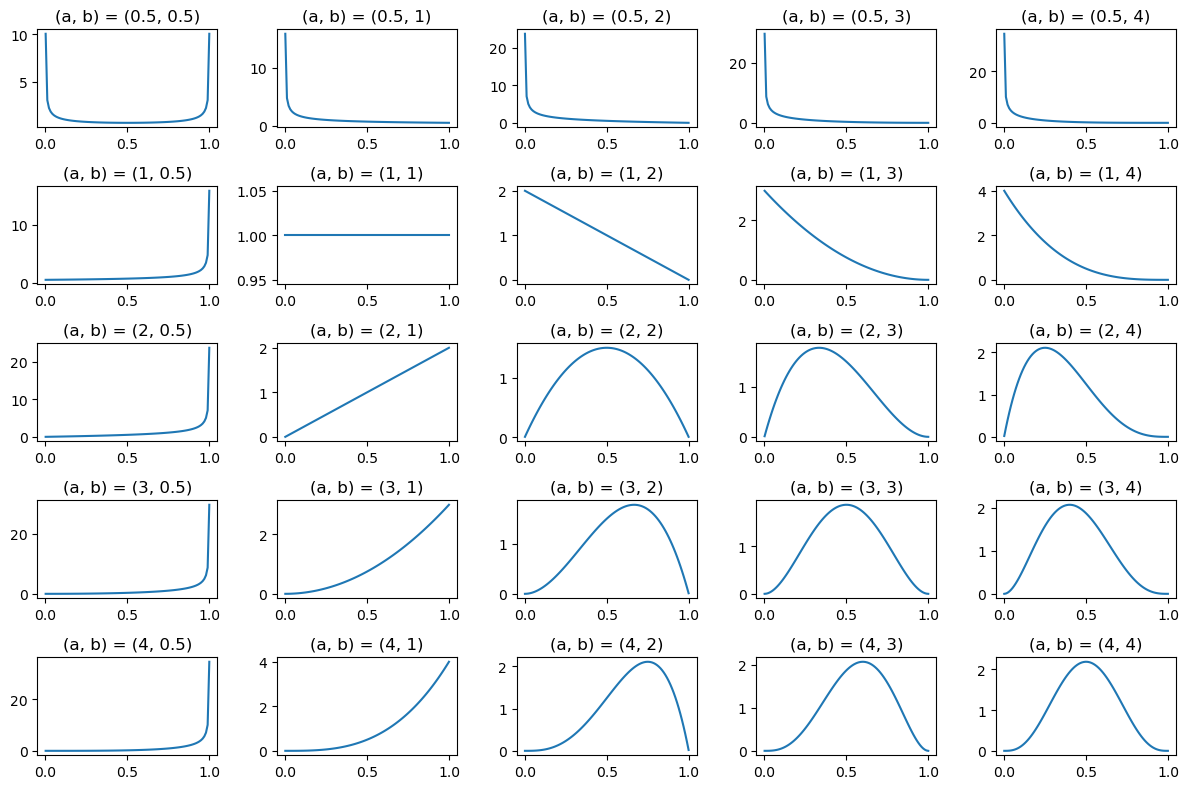

In [49]:
plt.figure(figsize = (12, 8))

alpha = [.5, 1, 2, 3, 4]
beta = alpha[:]
x = np.linspace(.001, .999, num = 100)

for i, (a, b) in enumerate(itertools.product(alpha, beta)):
    plt.subplot(len(alpha), len(beta), i+1)
    sns.lineplot(x=x, y=scipy.stats.beta.pdf(x, a, b))
    plt.title('(a, b) = ({}, {})'.format(a,b))

plt.tight_layout()   

You can see from the plots above, that the beta distribution can take on quite a range of shapes, depending on the parameters. Generally if $a \gt b$ the distribution skews to the rights, if $a \lt b$ to the left, and symmetric if $ a = b$.

We still do not know a lot about the behavior of drivers, so we will pick a rather vague or broad beta distribution as our prior. The code in the cell below uses a symmetric prior with $a = 2$ and $b = 2$.

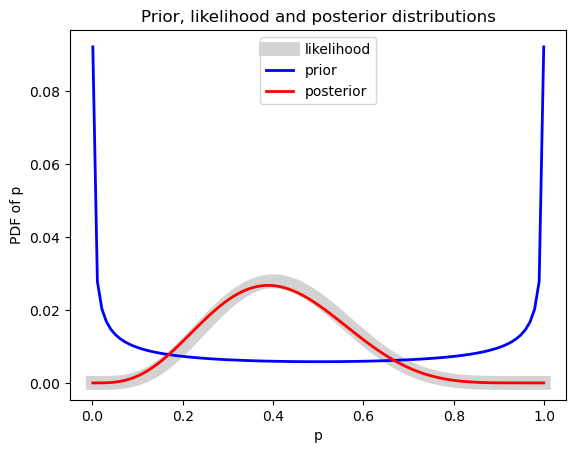

In [51]:
def beta_prior(x, a, b):
    l = scipy.stats.beta.pdf(x, a, b)  # compute likelihood
    return l / l.sum()  # normalize and return

prior = beta_prior(x,  0.5, 0.5)
post = posterior(prior, like)
plot_pp(x, prior, like, post)

Notice that the mode of the posterior is close to the mode of the likelihood, but has shifted toward the mode of the prior. We call this tendency of Bayesian posteriors to be shifted toward the prior the **shrinkage property**. The tendency of the maximum likelihood point of the posterior is said to shrink toward the maximum likelihood point of the prior. 

We can now see that the posterior probability of distracted driving has a rather wide spread. How can we get a more definitive understanding of the probability of distracted driving?

### Adding data to the Bayesian model

Let's say that we observe some more drivers and gather some more data on distracted driving. Additional data will narrow the spread of the posterior distribution. As you might expect, adding more observations to the model, moves the posterior closer to the likelihood. 

In fact, as data is added to a Bayesian model, the posterior moves toward the likelihood. This property has two important implications:

- The prior matters less as more data is added to a Bayesian model.
- Adding data reduces shrinkage.
- The inferences from Bayesian and frequentist models tend to converge as data set sizes grow and the posterior approaches the likelihood.

**But, be careful!** With large scale problems with large numbers of parameters you may need enormous data sets to see the convergence in behavior. 

The code in the cell below adds another 10 observations to our data set. Execute this code and examine the results. How do the likelihood and posterior distributions compare with the case with only 10 data points.

<>:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\Alissa\AppData\Local\Temp\ipykernel_21004\2787844778.py:2: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  new_distracted = [1 if x is 'yes' else 0 for x in new_drivers]


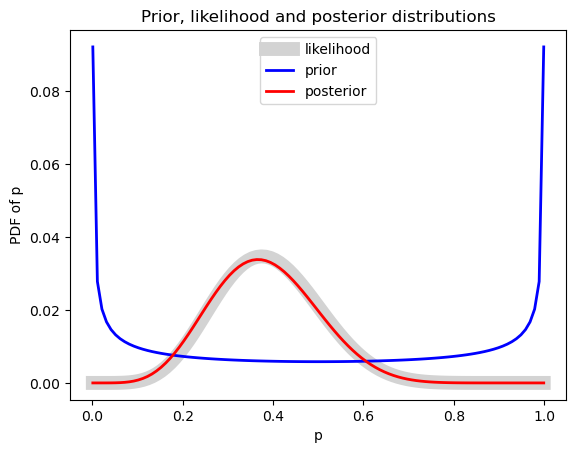

In [54]:
new_drivers = ['no', 'yes', 'no', 'yes', 'no', 'no']  # new data
new_distracted = [1 if x is 'yes' else 0 for x in new_drivers]

like = likelihood(x, distracted + new_distracted)
post = posterior(prior, like)
plot_pp(x, prior, like, post)

You can change the new data to be a series of `no` values or a series of `yes` values and see how the distribution changes accordingly.

### Simulating new data

So once we have the posterior distribution, what do we do with it? For starters, because it's a distribution, we can draw samples from it, similar to what we do with simulations. So far we've learned how to draw samples from pre-defined distributions like the normal or binomial by calling `np.random.normal(size = 10)` for example. But how do we draw samples from an undefined posterior distribution? We use `np.random.choice`, give it the values that we want to sample from, and use the posterior distribution as a **sampling weight** (see the `p` argument below).

In [56]:
np.random.choice(x, size = 10, p = post) # draw samples from the posterior distribution

array([0.53528283, 0.45463636, 0.42439394, 0.46471717, 0.27318182,
       0.40423232, 0.43447475, 0.45463636, 0.29334343, 0.18245455])

So far, we have drawn from the posterior distribution of the probability parameter $p$. But what about the distribution of distracted drivers? To get that, we need to rely on the fact that if we have $n$ drivers and $p$ is the probability of a driver being distracted, then $np$ is the number of distracted drivers. Since we are treating $p$ not as a fixed value but a random variable, the more correct way to write it is $nP$ (using an upper-case).

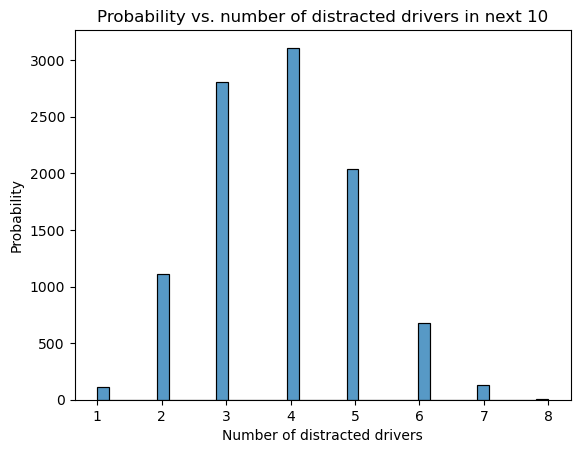

In [58]:
num_cars = 10
num_samples = 10000

counts = (num_cars * np.random.choice(x, size = num_samples, replace = True, p = post)).round()
sns.histplot(counts, kde = False)
plt.title('Probability vs. number of distracted drivers in next %d' % num_cars)
plt.xlabel('Number of distracted drivers')
plt.ylabel('Probability');

## Credible intervals

A **credible interval** is an interval on the Bayesian posterior distribution. The credible interval is sometimes called the highest density interval (HDI), or highest posterior density interval (HPI). As an example, the 90% credible interval encompasses the 90% of the posterior distribution with the highest probability density.  

The credible interval is the Bayesian analog of the frequentist confidence interval. However, these two measures are conceptually different. The confidence interval is chosen on the distribution of a test statistic, whereas the credible interval is computed on the posterior distribution of the parameter. For symmetric distributions the credible interval can be numerically the same as the confidence interval. However, in the general case, these two quantities can be quite different.  

The code in the cell below, plots the posterior distribution of the parameter of the binomial distribution parameter $p$.

***
<span style="color: magenta;">**Warning!**</span> This code assumes a symmetric prior distribution, so will not work in the general case. 
***

The 0.950 credible interval is 0.025 to 0.975


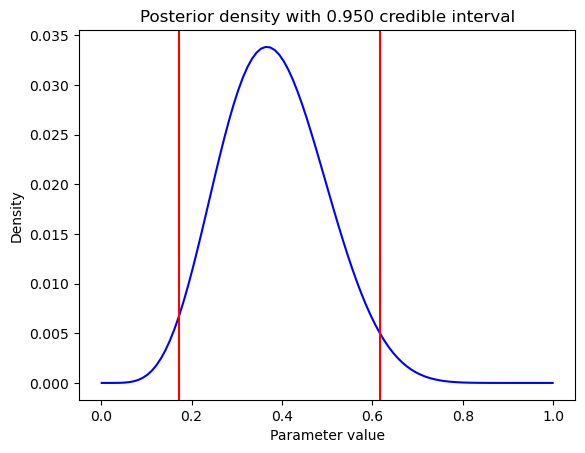

In [60]:
num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(x=p, y=post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))
    
plot_ci(x, post, num_samples, lower_q, upper_q)

# Assignment

How can we use Bayesian models to compare two distributions? It turns out that we can compare Bayesian models in several ways. In this assignment, we will compute and compare credible intervals of the posterior distribution of a model parameter.

Before we begin, let's load the libraries and functions we need.

In [5]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import itertools

In [6]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(p, post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))


For this example, we will compare the posterior distribution of the heights of sons to the heights of the mothers in the Galton family dataset. As a first step, we will compute and evaluate Bayesian models for the mean heights using a subset of just 25 observations. 

In [8]:
families = pd.read_csv('./data/GaltonFamilies.csv', index_col = 0)
families.head()
#families.columns
#families.shape

,father,mother,midparentHeight,children,childNum,gender,childHeight
family,,,,,,,
001,78.5,67.0,75.43,4,1,male,73.2
001,78.5,67.0,75.43,4,2,female,69.2
001,78.5,67.0,75.43,4,3,female,69.0
001,78.5,67.0,75.43,4,4,female,69.0
002,75.5,66.5,73.66,4,1,male,73.5


In [9]:
families.index

Index(['001', '001', '001', '001', '002', '002', '002', '002', '003', '003',
       ...
       '200', '201', '201', '202', '202', '203', '203', '203', '204', '204'],
      dtype='object', name='family', length=934)

1
- Plot the distributions of the height of mothers and sons for a sample of size 25. Do the distributions appear to be significantly different? <span style="color:red" float:right>[5 point]</span>

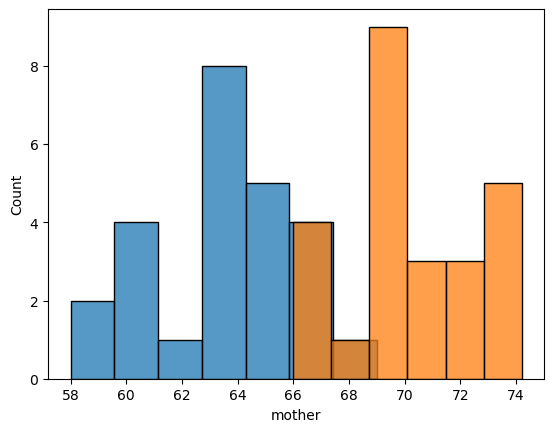

In [11]:
np.random.seed(123)
num_samples = 25
fig = sns.histplot(x = families["mother"].sample(n = num_samples), data = families)
fig = sns.histplot(x = families.loc[families["gender"] == "male", "childHeight"].sample(n = num_samples), data = families)


To perform this analysis, we need to select a prior distribution, which is easy, and to compute the likelihood, which is not as easy. So first, let's see how we can get the likelihood.

For this data, we will use a normal likelihood. For something like heights, using the normal distribution makes sense. For any individual sample $X$ if it follows the normal distribution with mean $\mu$ and standard deviation $\sigma$, then it probability density function is given by

$$X \sim N(\mu, \sigma) \Rightarrow P(X | \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Bigg[ -\frac{1}{2}\big(\frac{X - \mu}{\sigma}\big)^2\Bigg]$$

For a sample ${X_1, X_2, \cdots, X_n}$ of $n$ independent normally distributed observations has the following likelihood:

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) = \prod_{i = 1}^n P(X_i | \mu, \sigma) = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Bigg[ -\frac{1}{2}\big(\frac{X_i - \mu}{\sigma}\big)^2\Bigg]$$

Notice that we multiply the individual the probabilities to get the likelihood. We can do this because we assume that the data points are independent. This seems like a relatively safe assumption. 

Now let's simplify the above equation. We can simplify things by ignoring the terms outside the exponential, since they don't depend on the sample, and replacing $=$ (is equal to) with $\propto$ (is proportional to):

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) \propto \prod_{i = 1}^n \exp \Bigg[ -\frac{1}{2}\big(\frac{X_i - \mu}{\sigma}\big)^2\Bigg]$$

Moreover, we can rely on the property $e^a e^b = e^{a + b}$ to rewrite the right-hand side as

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) \propto \exp \Bigg[ -\frac{1}{2} \sum_{i = 1}^n \big(\frac{X_i - \mu}{\sigma}\big)^2\Bigg]$$

Finally, letting $\bar X = \frac{1}{n}\sum_{i=1}^n X_i$ we can rewrite $X_i - \mu$ as $X_i - \bar X + \bar X - \mu$ and after some rearranging we get this:

$$P(X_1, X_2, \cdots, X_n | \mu, \sigma) \propto \exp \Bigg[ -\frac{1}{2 \sigma^2}  \Bigg( \sum_{i = 1}^n (X_i - \bar{X})^2 + n(\bar{X} - \mu)^2 \Bigg) \Bigg]$$

To simplify the computations here, we will only estimate the posterior distribution of $\mu$. We will use a fixed empirical estimate of the standard deviation. A more complete analysis will also estimate the posterior distribution of $\sigma$.

2 
- Now your task is to write a function called `likelihood` that computes the likelihood as given by the above equation. The input of the function is `mu` (the parameter) and `x` (the data) and its output is the likelihood of the data given the parameter. You may find it helpful to use `np.exp` and `np.sum`. <span style="color:red" float:right>[10 point]</span>

In [14]:
def likelihood(mu, x): 
    #mu = population's average (float)
    #x = data points (array)
    sigma = np.std(x) #population's std (approximated with sample's std)
    #print("sigma",sigma)
    number = len(x) #size of sum / aka sample size
    #print("size",number)
    x_bar = np.mean(x) #sample's average
    #print("average",x_bar)
    constant = ( number*( (x_bar-mu)**2 ) )
    #print("constant",constant)
    sigma_sum = np.sum( ( (x-x_bar)**2 )  ) 
    interior = sigma_sum + constant
    #print("sum",interior)
    probability = np.exp(-0.5/(sigma**2)*interior)
    #print("probability",probability)

    return probability / probability.sum()

Now for the prior distribution, we will use a normal distribution centered at 70 with standard deviation 1. The code for the prior is already written. Examine it and make sure you understand each step.

In [16]:
N = 1000 #N = 1000 #Size of the sum, approximating the rows in the dataframe
mu = np.linspace(60, 80, num = N) #creating a variable population average between (60,80) in a list len of 1000
mu_norm = mu / mu.sum()
print(mu_norm[0:10])
prior_center = 70 #previous known average from the sample of son's heights
prior = scipy.stats.norm.pdf(mu, loc = prior_center, scale = 1) #Probability density function
    #if given mu (pop. avg), loc (samp. avg), and scale (samp. std)
prior = prior / prior.sum() # normalize
print(prior)

[0.00085714 0.00085743 0.00085771 0.000858   0.00085829 0.00085857
 0.00085886 0.00085914 0.00085943 0.00085972]
[1.54046019e-24 1.88152194e-24 2.29717473e-24 2.80352678e-24
 3.42011982e-24 4.17065117e-24 5.08384555e-24 6.19450721e-24
 7.54478923e-24 9.18572406e-24 1.11790684e-23 1.35995258e-23
 1.65374236e-23 2.01019353e-23 2.44249580e-23 2.96657761e-23
 3.60166684e-23 4.37096466e-23 5.30245494e-23 6.42987622e-23
 7.79388821e-23 9.44347135e-23 1.14376050e-22 1.38472795e-22
 1.67579062e-22 2.02722049e-22 2.45136597e-22 2.96306550e-22
 3.58014228e-22 4.32399571e-22 5.22030836e-22 6.29989040e-22
 7.59968804e-22 9.16398713e-22 1.10458492e-21 1.33088241e-21
 1.60289913e-21 1.92973927e-21 2.32229299e-21 2.79358134e-21
 3.35916678e-21 4.03764141e-21 4.85120760e-21 5.82636795e-21
 6.99474505e-21 8.39405491e-21 1.00692624e-20 1.20739519e-20
 1.44719536e-20 1.73392702e-20 2.07663611e-20 2.48608471e-20
 2.97507131e-20 3.55880973e-20 4.25537751e-20 5.08624590e-20
 6.07690639e-20 7.25761078e-20 8.

Now we're ready to compute the posterior for both mother and son.

3
- Compute the posterior distribution for the sons (the column name is `childHeight`). You will need to compute the likelihood first. Then plot the prior, posterior and likelihood just like we did in class. <span style="color:red" float:right>[10 point]</span>

In [18]:
#write a function to update posterior
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

In [19]:
#array of son's heights
data = np.array(families.loc[families["gender"] == "male", "childHeight"])
print(len(data))
data_norm = data/data.sum()
data_norm
#scipy.stats.describe(data)

481


array([0.00219809, 0.0022071 , 0.00217707, 0.00213203, 0.00211702,
       0.00205696, 0.00216206, 0.00207197, 0.00204194, 0.00229719,
       0.00222212, 0.00219209, 0.00219209, 0.00222212, 0.002102  ,
       0.00213203, 0.00204194, 0.00201192, 0.00213203, 0.00211702,
       0.00216206, 0.00211702, 0.00210801, 0.00210801, 0.00207798,
       0.00222212, 0.00219209, 0.00214704, 0.00187679, 0.00219809,
       0.00219209, 0.00218308, 0.00219209, 0.00219209, 0.00213203,
       0.00222812, 0.00211702, 0.00208699, 0.00211702, 0.00211702,
       0.00207197, 0.00207197, 0.00201192, 0.00219209, 0.00201192,
       0.00213203, 0.002102  , 0.002102  , 0.00222212, 0.00216206,
       0.00207197, 0.00216206, 0.00214704, 0.00214704, 0.002102  ,
       0.00234223, 0.00222212, 0.00219209, 0.00216206, 0.00219809,
       0.00219209, 0.00207197, 0.002102  , 0.002102  , 0.00207197,
       0.00205696, 0.00213203, 0.00228217, 0.00216206, 0.00213203,
       0.00198189, 0.00211702, 0.00216206, 0.00216206, 0.00213

In [52]:
#compute the likelihood first
#like = likelihood(mu_norm, data_norm)
like_sons = likelihood(mu, data)
print(like_sons.shape)

#print(like_sons)
#Compute the posterior distribution
post_sons = posterior(prior, like_sons)
post_sons.shape
#print(post)

(1000,)


(1000,)

In [21]:
#Write a function to plot prior, post, and likelihood
def plot_pp(x, p, l, pp):
    sns.lineplot(x=x, y=l, color = 'lightgrey', linewidth = 10,label='likelihood')
    sns.lineplot(x=x, y=p, color = 'blue', linewidth = 2,label='prior')
    sns.lineplot(x=x, y=pp, color = 'red', linewidth = 2,label='posterior')
    plt.xlabel('Mu')
    plt.ylabel('PDF of Mu')
    plt.title('Prior, likelihood and posterior distributions')
    #plt.legend(labels = ['likelihood', 'prior', 'posterior'])
    return None

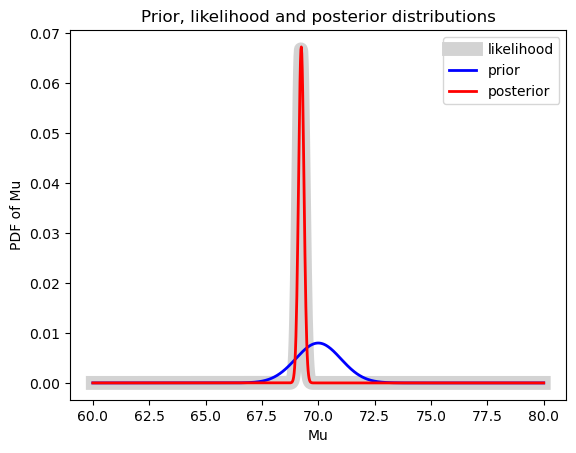

In [22]:
#plot the prior, posterior and likelihood
plot_pp(mu, prior, like_sons, post_sons)

#the plot was mu vs P, since mu was the parameter we were testing

4

- Compute the posterior distribution for mothers (the column name is `mother`). You will need to compute the likelihood first. Sons and mothers both use the same prior. Then plot the prior, posterior and likelihood just like we did in class. <span style="color:red" float:right>[5 point]</span>

In [24]:
moms_height = families.copy()
moms_height["family_index"] = moms_height.index
moms_height = moms_height.groupby(by = "family_index").mean("mother")
moms_height.head()
moms_height_array = np.array(moms_height.loc[:,"mother"])
moms_height_array
#moms_height.shape

array([67. , 66.5, 64. , 64. , 58.5, 68. , 68. , 66.5, 66. , 65.5, 62. ,
       61. , 67. , 67. , 66.5, 65. , 64.5, 64. , 63. , 69. , 68. , 67. ,
       65. , 65.5, 64. , 63. , 63. , 63. , 63.5, 62. , 62. , 62. , 62. ,
       61. , 69. , 67. , 66. , 66. , 66. , 66. , 65.5, 65.5, 65.5, 65. ,
       65. , 64. , 64.5, 64. , 64.5, 64.5, 63. , 63.5, 63. , 63. , 62. ,
       62. , 62.5, 62. , 61. , 58. , 69. , 69. , 68. , 67. , 67. , 66.5,
       65. , 65. , 65. , 65. , 65. , 65. , 65. , 65. , 64.7, 64. , 64. ,
       64.2, 64. , 64.5, 64. , 64. , 63.7, 63. , 63. , 63.5, 63. , 63. ,
       62. , 62.7, 62. , 61. , 60. , 60. , 58.5, 58. , 68.5, 67. , 66. ,
       66. , 66.7, 66. , 66.5, 66.5, 66.5, 66. , 66. , 65. , 64.5, 64. ,
       63.5, 63. , 63. , 63. , 63.5, 63.5, 62. , 62. , 62. , 62. , 62.5,
       62. , 61. , 61. , 60. , 60. , 60.5, 70.5, 67. , 66.5, 65. , 65.5,
       65.5, 65. , 65. , 64. , 65. , 64. , 64. , 64.5, 64. , 63. , 63.5,
       63. , 63. , 63. , 63. , 63.5, 63. , 63.5, 62

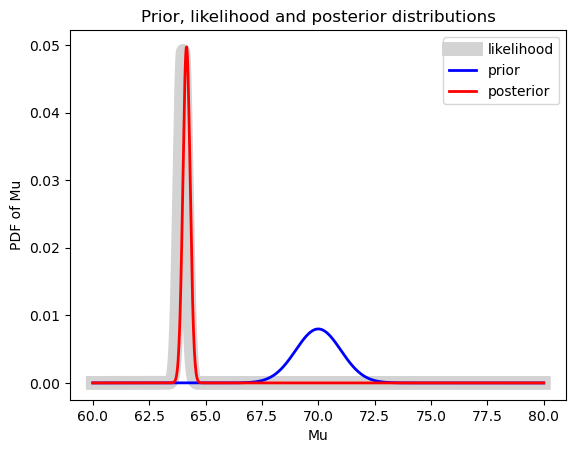

In [25]:

data_mom = np.array(families.loc[:, "mother"])

like_mom = likelihood(mu, moms_height_array)

post_mom = posterior(prior, like_mom)

plot_pp(mu, prior, like_mom, post_mom)


To compare the posterior distributions of the mean heights of the sons to the distribution of the mean heights of the mothers, we compute and compare the confidence intervals. 

5
- Use the `plot_ci` function to plot credible intervals for mother and son heights. You can call the function twice in the same cell and the two distributions will be plotted next to each other in one plot. What conclusion do you draw about the heights of mothers versus sons? <span style="color:red" float:right>[10 point]</span>

The 0.950 credible interval is 0.025 to 0.975
The 0.950 credible interval is 0.025 to 0.975


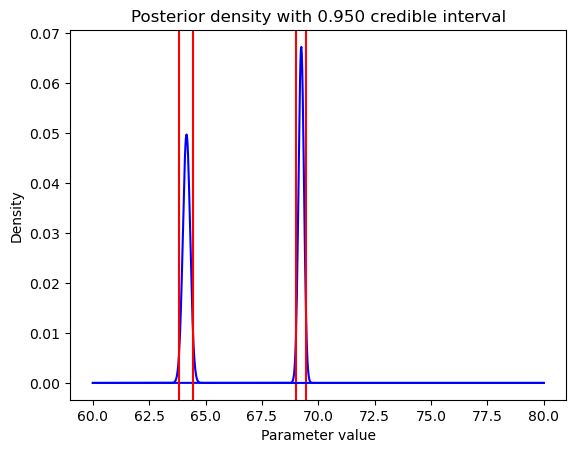

In [27]:
num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(x=p, y=post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))
    
fig1 = plot_ci(mu, post_sons, num_samples, lower_q, upper_q)
fig2 = plot_ci(mu, post_mom, num_samples, lower_q, upper_q)

Since the CIs don't even overlap, it can follow that the sons were significantly taller than their mothers.

# End of assignment